# **Predictive Maintenance System**

## **1️⃣ Load Required Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
import joblib
import warnings
warnings.filterwarnings("ignore")

## **2️⃣ Load & Explore Data**

In [2]:
# Load dataset
df = pd.read_csv("predictive_maintenance.csv")

In [3]:
# Display first few rows
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [4]:
# Check for missing values
df.isnull().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64

In [5]:
# Summary statistics
df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


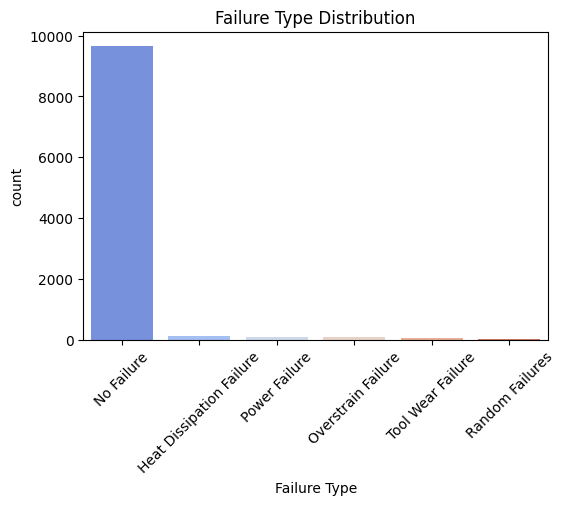

In [6]:
# Class distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Failure Type', order=df['Failure Type'].value_counts().index, palette="coolwarm")
plt.title("Failure Type Distribution")
plt.xticks(rotation=45)
plt.show()

## **3️⃣ Data Preprocessing with Sklearn Pipelines**

In [7]:
from sklearn.impute import SimpleImputer

# Drop unique identifiers
df.drop(columns=['UDI', 'Product ID'], inplace=True)

# Define categorical & numerical columns
categorical_cols = ['Type']
numerical_cols = ['Air temperature [K]', 'Process temperature [K]', 
                  'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

# Column Transformer Pipeline
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical_cols),
    ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# Define X and y
X = df.drop(columns=['Target', 'Failure Type'])
y = df['Target'].astype(int)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Transform data using pipeline
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Save the preprocessor for later use
joblib.dump(preprocessor, 'preprocessor.pkl')

['preprocessor.pkl']

## **4️⃣ Try Multiple ML Models**

In [8]:
# Define models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(),
    "SVM": SVC(),
    "MLP Classifier": MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=300, random_state=42)
}

# Train & Evaluate
for name, model in models.items():
    model.fit(X_train_transformed, y_train)
    y_pred = model.predict(X_test_transformed)
    print(f"\n🔹 Model: {name}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))


🔹 Model: Random Forest
Accuracy: 0.9805
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1932
           1       0.89      0.49      0.63        68

    accuracy                           0.98      2000
   macro avg       0.94      0.74      0.81      2000
weighted avg       0.98      0.98      0.98      2000


🔹 Model: Gradient Boosting
Accuracy: 0.9855
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1932
           1       0.88      0.66      0.76        68

    accuracy                           0.99      2000
   macro avg       0.94      0.83      0.87      2000
weighted avg       0.98      0.99      0.98      2000


🔹 Model: SVM
Accuracy: 0.9720
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1932
           1       0.88      0.21      0.33        68

    accuracy                           0.97      2000
   macro av

## **5️⃣ Hyperparameter Tuning using GridSearchCV**

In [9]:
# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train_transformed, y_train)

# Best Parameters
print("Best Hyperparameters:", grid_search.best_params_)

# Evaluate best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_transformed)
print(f"Optimized Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))

# Save the best Random Forest model
joblib.dump(best_model, 'random_forest_model.pkl')

Best Hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Optimized Accuracy: 0.9815
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1932
           1       0.90      0.51      0.65        68

    accuracy                           0.98      2000
   macro avg       0.94      0.76      0.82      2000
weighted avg       0.98      0.98      0.98      2000



['random_forest_model.pkl']

## **6️⃣ Deep Learning Model (ANN)**

In [10]:
# Build ANN Model
ann_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_transformed.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile Model
ann_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train Model
ann_model.fit(X_train_transformed, y_train, epochs=30, batch_size=16, validation_data=(X_test_transformed, y_test))

# Evaluate ANN Model
y_pred_ann = (ann_model.predict(X_test_transformed) > 0.5).astype(int)
print(f"ANN Accuracy: {accuracy_score(y_test, y_pred_ann):.4f}")
print(classification_report(y_test, y_pred_ann))

# Save ANN model
ann_model.save("ann_model.h5")

Epoch 1/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8740 - loss: 0.3025 - val_accuracy: 0.9660 - val_loss: 0.1068
Epoch 2/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9706 - loss: 0.1025 - val_accuracy: 0.9670 - val_loss: 0.0975
Epoch 3/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9708 - loss: 0.0988 - val_accuracy: 0.9680 - val_loss: 0.0921
Epoch 4/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9688 - loss: 0.1081 - val_accuracy: 0.9675 - val_loss: 0.0903
Epoch 5/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9737 - loss: 0.0833 - val_accuracy: 0.9690 - val_loss: 0.0850
Epoch 6/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9682 - loss: 0.0971 - val_accuracy: 0.9700 - val_loss: 0.0841
Epoch 7/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9770 - loss: 0.0783 - val_accuracy: 0.9715 - val_loss: 0.0804
Epoch 8/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9733 - loss: 0.0821 - val_accuracy: 0.

ANN Accuracy: 0.9765
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1932
           1       0.80      0.41      0.54        68

    accuracy                           0.98      2000
   macro avg       0.89      0.70      0.77      2000
weighted avg       0.97      0.98      0.97      2000



## **7️⃣ LSTM-Based Model for Time-Series Data**

In [11]:
# Reshape input data for LSTM
X_train_lstm = np.expand_dims(X_train_transformed, axis=1)
X_test_lstm = np.expand_dims(X_test_transformed, axis=1)

# Build LSTM Model
lstm_model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(1, X_train_transformed.shape[1])),
    LSTM(32, activation='relu', return_sequences=False),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile Model
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train Model
lstm_model.fit(X_train_lstm, y_train, epochs=30, batch_size=16, validation_data=(X_test_lstm, y_test))

# Evaluate LSTM Model
y_pred_lstm = (lstm_model.predict(X_test_lstm) > 0.5).astype(int)
print(f"LSTM Accuracy: {accuracy_score(y_test, y_pred_lstm):.4f}")
print(classification_report(y_test, y_pred_lstm))

# Save LSTM model
lstm_model.save("lstm_model.h5")

Epoch 1/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9578 - loss: 0.3517 - val_accuracy: 0.9660 - val_loss: 0.1197
Epoch 2/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9667 - loss: 0.1144 - val_accuracy: 0.9665 - val_loss: 0.0960
Epoch 3/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9716 - loss: 0.0913 - val_accuracy: 0.9690 - val_loss: 0.0887
Epoch 4/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9737 - loss: 0.0838 - val_accuracy: 0.9695 - val_loss: 0.0869
Epoch 5/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9719 - loss: 0.0844 - val_accuracy: 0.9695 - val_loss: 0.0867
Epoch 6/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9747 - loss: 0.0773 - val_accuracy: 0.9750 - val_loss: 0.0784
Epoch 7/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9754 - loss: 0.0717 - val_accuracy: 0.9730 - val_loss: 0.0790
Epoch 8/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9780 - loss: 0.0655 - val_accuracy: 0.


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1932
           1       0.78      0.74      0.76        68

    accuracy                           0.98      2000
   macro avg       0.89      0.86      0.87      2000
weighted avg       0.98      0.98      0.98      2000



## **🎯 Features Implemented**

### ✅ Sklearn Pipelines for Data Preprocessing
### ✅ Multiple ML Models (Random Forest, SVM, Gradient Boosting)
### ✅ Hyperparameter Tuning with GridSearchCV
### ✅ Deep Learning Models (ANN, LSTMs)
### ✅ FastAPI Deployment